In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_visualize
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg
import astropy.table as table

In [3]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [4]:
S0_fid = jsm_ancillary.load_sample("../../data/S0_sample/radial_dependance/S0_fid.h5")
S0_off = jsm_ancillary.load_sample("../../data/S0_sample/radial_dependance/S0_off.h5")
S0_down = jsm_ancillary.load_sample("../../data/S0_sample/radial_dependance/S0_down.h5")
S0_up = jsm_ancillary.load_sample("../../data/S0_sample/radial_dependance/S0_up.h5")

In [5]:
dsph_mw = table.Table.read('../../../misc/local_volume_database/data/dwarf_mw.csv')
MW_rad = dsph_mw["distance_gc"].value
MW_logMstar = dsph_mw["mass_stellar"].value

In [145]:
def radial_distribution(sample, label, plot_MW=False):

    Rvir = 258.924 #kpc
    log_fR_bins = np.linspace(-1.5, 0, 25)
    bin_centers = (log_fR_bins[:-1] + log_fR_bins[1:]) / 2

    rmag_mat = jsm_ancillary.make_matrix(sample, "sat_final_rmag")
    final_mass_mat = jsm_ancillary.make_matrix(sample, "sat_mass")
    art_mass_mat = jsm_ancillary.make_matrix(sample, "sat_art_mass")

    rmag_mat = np.where(rmag_mat < Rvir, rmag_mat, np.nan)

    no_art = final_mass_mat > art_mass_mat
    rmag_mat_masked = np.where(no_art, rmag_mat, np.nan)

    log_fR = np.log10(rmag_mat/Rvir)
    log_fR_masked = np.log10(rmag_mat_masked/Rvir)

    count_mat = np.apply_along_axis(jsm_stats.radii_grthan, axis=1, arr=log_fR, bins=log_fR_bins)
    count_mat_masked = np.apply_along_axis(jsm_stats.radii_grthan, axis=1, arr=log_fR_masked, bins=log_fR_bins)

    perc_mat = np.log10(np.percentile(count_mat, [16, 50, 84], axis=0))
    perc_mat_masked = np.log10(np.percentile(count_mat_masked, [16, 50, 84], axis=0))

    perc_mat[~np.isfinite(perc_mat)] = 0.0
    perc_mat_masked[~np.isfinite(perc_mat_masked)] = 0.0

    output_rad =  [bin_centers, perc_mat, perc_mat_masked]

    plt.plot(output_rad[0], output_rad[1][1], color="navy", label=label)
    plt.fill_between(output_rad[0], y1=output_rad[1][0], y2=output_rad[1][2], color="navy", alpha=0.2)

    plt.plot(output_rad[0], output_rad[2][1], color="darkorange", label="artificial disruption")
    plt.fill_between(output_rad[0], y1=output_rad[2][0], y2=output_rad[2][2], color="orange", alpha=0.2)

    if plot_MW:
        logR_MW = np.log10(MW_rad/Rvir)
        counts_MW = np.log10(jsm_stats.radii_grthan(logR_MW, log_fR_bins))
        plt.plot(bin_centers, counts_MW, marker="s", color="k", label="MW dsph\nPace et al. 2024")

    plt.xlim(output_rad[0].min(), output_rad[0].max())
    plt.ylim(0, 2.2)
    plt.legend(loc=3)

    plt.ylabel("log $(N > \\mathcal{R})$")
    plt.xlabel("log [$\\mathcal{R} \equiv r/R_{\\rm vir}$]")

    plt.show()

    return output_rad

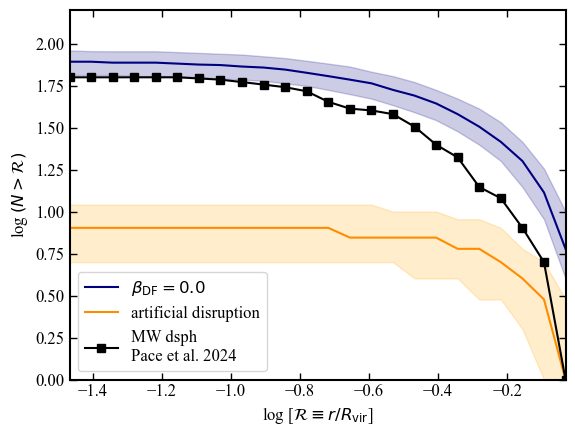

In [170]:
S0_off_rad = radial_distribution(S0_off, "$\\beta_{\\rm DF} = 0.0$", plot_MW=True)

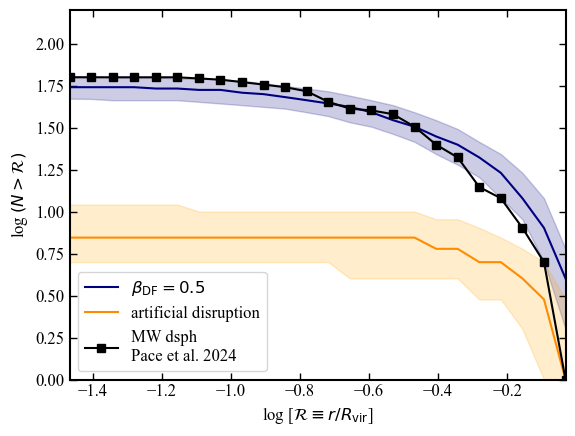

In [171]:
S0_down_rad = radial_distribution(S0_down, "$\\beta_{\\rm DF} = 0.5$", plot_MW=True)

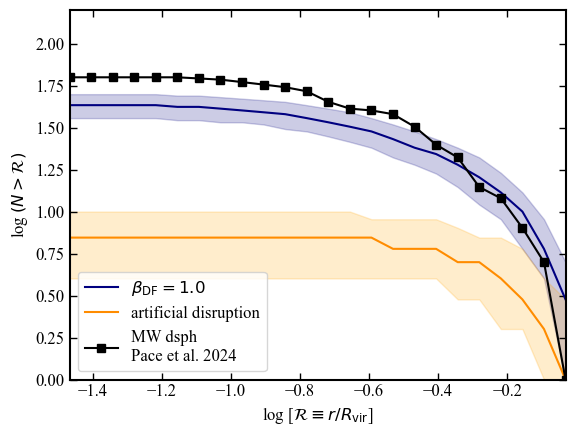

In [172]:
S0_fid_rad = radial_distribution(S0_fid, "$\\beta_{\\rm DF} = 1.0$", plot_MW=True)

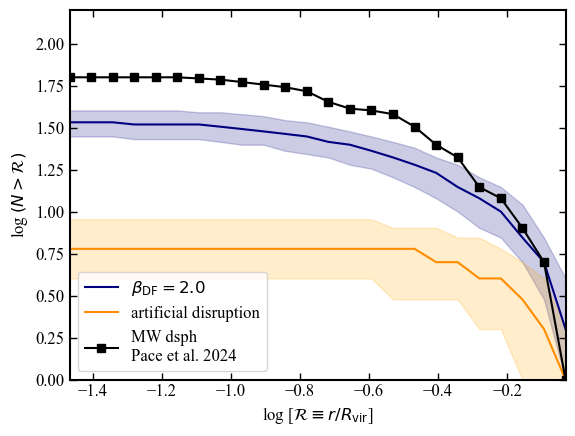

In [173]:
S0_up_rad = radial_distribution(S0_up, "$\\beta_{\\rm DF} = 2.0$", plot_MW=True)

In [150]:
def mass_function(sample, label, plot_MW=False):

    Rvir = 258.924 #kpc
    log_mstar_bins = np.linspace(4.5, 10, 25)
    bin_centers = (log_mstar_bins[:-1] + log_mstar_bins[1:]) / 2

    rmag_mat = jsm_ancillary.make_matrix(sample, "sat_final_rmag")
    final_mass_mat = np.log10(jsm_ancillary.make_matrix(sample, "sat_mass"))
    art_mass_mat = np.log10(jsm_ancillary.make_matrix(sample, "sat_art_mass"))

    final_stellarmass_mat = np.log10(jsm_ancillary.make_matrix(sample, "sat_stellarmass"))

    final_mass_mat = np.where(rmag_mat < Rvir, final_mass_mat, np.nan)
    art_mass_mat = np.where(rmag_mat < Rvir, art_mass_mat, np.nan)
    final_stellarmass_mat = np.where(rmag_mat < Rvir, final_stellarmass_mat, np.nan)

    no_art = final_mass_mat > art_mass_mat
    final_stellarmass_mat_masked = np.where(no_art, final_stellarmass_mat, np.nan)

    count_mat = np.apply_along_axis(jsm_stats.cumulative, axis=1, arr=final_stellarmass_mat, mass_bins=log_mstar_bins)
    count_mat_masked = np.apply_along_axis(jsm_stats.cumulative, axis=1, arr=final_stellarmass_mat_masked, mass_bins=log_mstar_bins)

    perc_mat = np.percentile(count_mat, [16, 50, 84], axis=0)
    perc_mat_masked = np.percentile(count_mat_masked, [16, 50, 84], axis=0)

    output_rad =  [bin_centers, perc_mat, perc_mat_masked]

    plt.plot(output_rad[0], output_rad[1][1], color="navy", label=label)
    plt.fill_between(output_rad[0], y1=output_rad[1][0], y2=output_rad[1][2], color="navy", alpha=0.2)

    plt.plot(output_rad[0], output_rad[2][1], color="darkorange", label="artificial disruption")
    plt.fill_between(output_rad[0], y1=output_rad[2][0], y2=output_rad[2][2], color="orange", alpha=0.2)

    if plot_MW:
        counts_MW = jsm_stats.cumulative(MW_logMstar, log_mstar_bins)
        plt.plot(bin_centers, counts_MW, marker="s", color="k", label="MW dsph\nPace et al. 2024")

    plt.xlim(output_rad[0].min(), output_rad[0].max())
    plt.ylim(1, 1e2)
    plt.legend(loc=1)
    plt.yscale("log")
    plt.ylabel("$N > m_{*}$")
    plt.xlabel("log $m_{*}$")

    plt.show()

    return output_rad

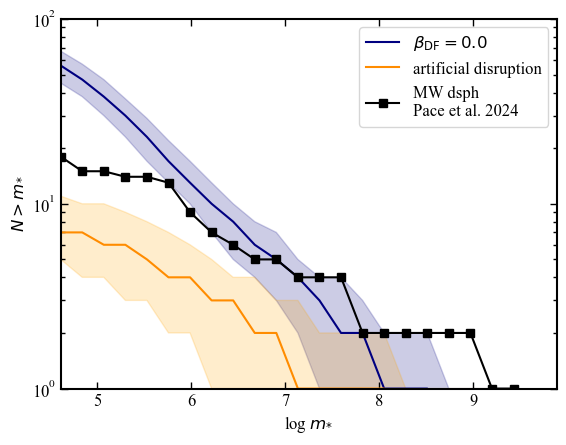

In [174]:
test = mass_function(S0_off, label="$\\beta_{\\rm DF} = 0.0$", plot_MW=True)

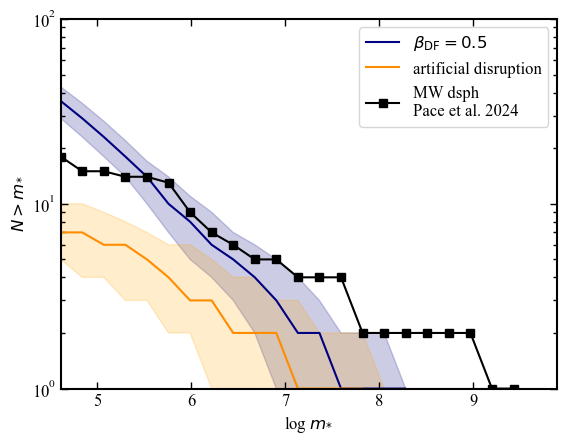

In [175]:
test = mass_function(S0_down, label="$\\beta_{\\rm DF} = 0.5$", plot_MW=True)

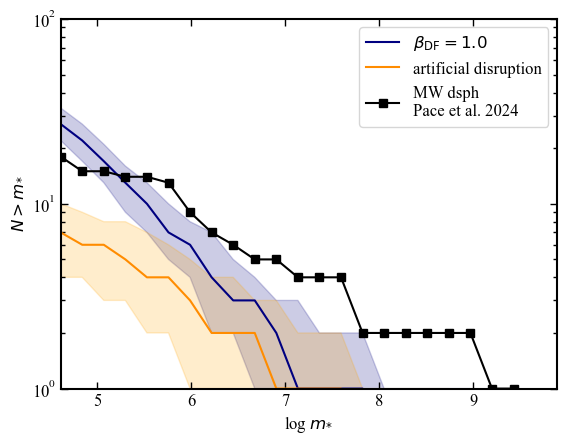

In [176]:
test = mass_function(S0_fid, label="$\\beta_{\\rm DF} = 1.0$", plot_MW=True)

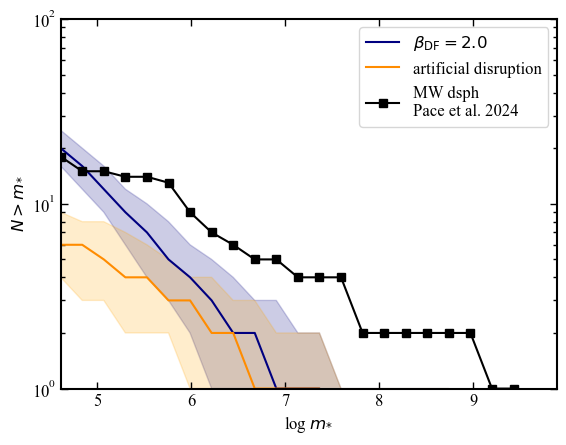

In [177]:
test = mass_function(S0_up, label="$\\beta_{\\rm DF} = 2.0$", plot_MW=True)

In [155]:
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import astropy.units as u


MW_pot = gp.NFWPotential.from_circular_velocity(v_c=200*u.km/u.s,
                                             r_s=10.*u.kpc,
                                             units=galactic)

# Radial grid
r = np.linspace(0.1, 500, 500) * u.kpc

# Positions in Cartesian coordinates (x=r, y=0, z=0)
xyz = np.zeros((3, len(r))) * u.kpc
xyz[0] = r

# Evaluate potential
phi = MW_pot.energy(xyz)  # specific energy (per unit mass)

# Escape velocity
v_esc = np.sqrt(-2 * phi)

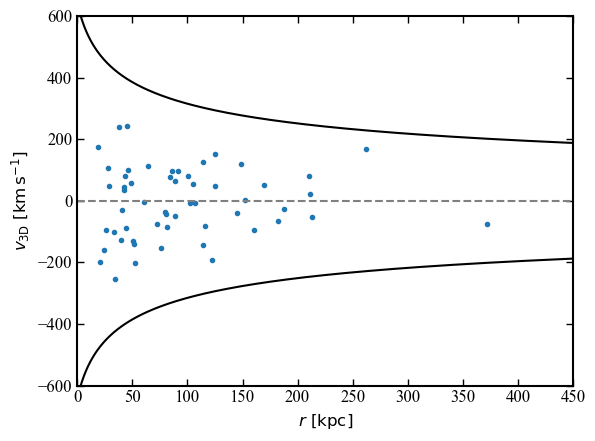

In [156]:
# Plot
fig, ax = plt.subplots()
ax.plot(r.to_value(u.kpc), v_esc.to_value(u.km/u.s), color="k")
ax.plot(r.to_value(u.kpc), -1*v_esc.to_value(u.km/u.s), color="k")

ax.scatter(dsph_mw["distance_gc"], dsph_mw["velocity_gsr"], marker=".")

ax.set_xlabel(r"$r\ \mathrm{[kpc]}$")
ax.set_ylabel(r"$v_{\rm 3D}\ \mathrm{[km\,s^{-1}]}$")
ax.axhline(0, ls="--", color="grey")

ax.set_xlim(0,450)
ax.set_ylim(-600,600)

plt.show()

In [157]:
def plot_distance_velocity(sample, host_index, label, plot_MW=False):

    fig, ax = plt.subplots()
    ax.plot(r.to_value(u.kpc), v_esc.to_value(u.km/u.s), color="k")

    if plot_MW:
        ax.scatter(dsph_mw["distance_gc"], np.abs(dsph_mw["velocity_gsr"]), marker=".", color="k", label="MW dsph\nPace et al. 2024")

    art_mask = sample["sat_mass"][host_index] > sample["sat_art_mass"][host_index]
    ax.scatter(sample["sat_final_rmag"][host_index], sample["sat_final_vmag"][host_index], marker="x", label="artifcially disrupted")
    ax.scatter(sample["sat_final_rmag"][host_index][art_mask], sample["sat_final_vmag"][host_index][art_mask], marker="s", label=label)

    ax.set_xlabel(r"$r\ \mathrm{[kpc]}$")
    ax.set_ylabel(r"$|v_{\rm 3D}\| \mathrm{[km\,s^{-1}]}$")
    ax.axhline(0, ls="--", color="grey")

    ax.set_xlim(0,450)
    ax.legend()

    plt.show()

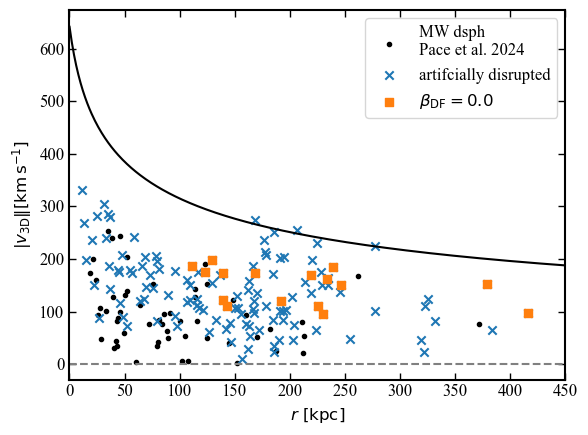

In [158]:
plot_distance_velocity(S0_off, 12, "$\\beta_{\\rm DF} = 0.0$", plot_MW=True)

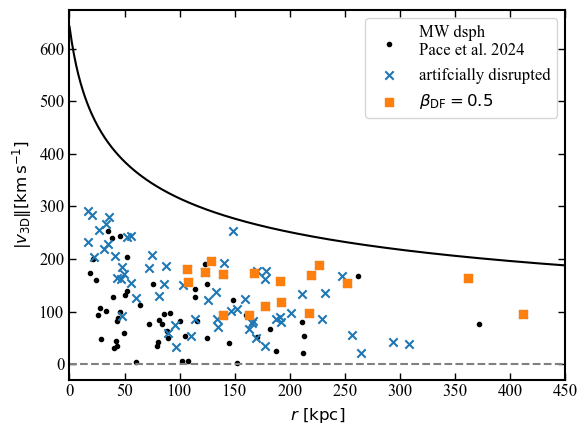

In [159]:
plot_distance_velocity(S0_down, 12, "$\\beta_{\\rm DF} = 0.5$", plot_MW=True)

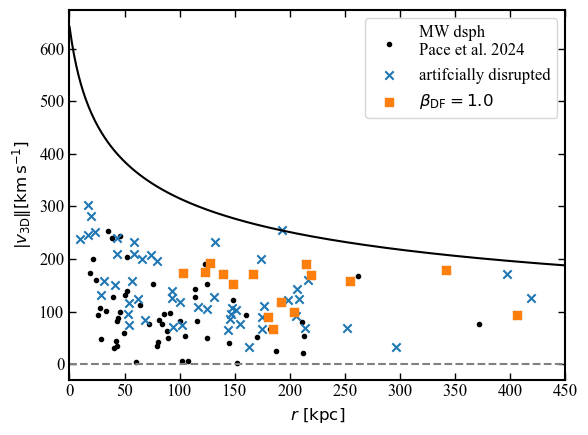

In [160]:
plot_distance_velocity(S0_fid, 12, "$\\beta_{\\rm DF} = 1.0$", plot_MW=True)

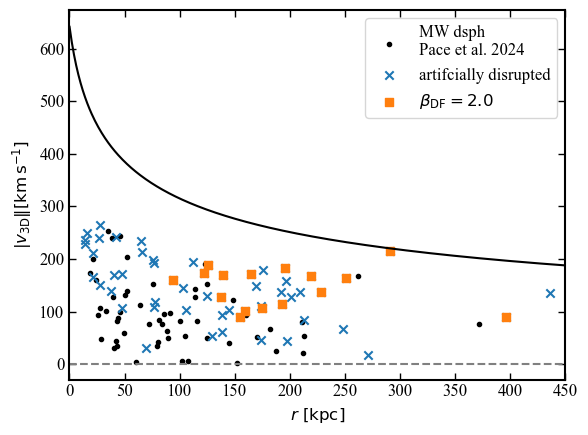

In [161]:
plot_distance_velocity(S0_up, 12, "$\\beta_{\\rm DF} = 2.0$", plot_MW=True)